If the ModuleCheck ran without any issue, run this to make sure the entire model works.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import importlib

import astropy
import astropy.units as u
import astropy.constants as c
from astropy.cosmology import default_cosmology
from scipy.interpolate import RegularGridInterpolator

In [138]:
# Plot Styling
plt.style.use('dark_background')
plt.rcParams.update({
    'font.family':'serif', 'mathtext.fontset':'dejavuserif',
    'axes.grid':True, 'grid.linestyle': ':', 'grid.alpha': 0.5,
    'xtick.direction':'in', 'xtick.minor.visible': True, 'xtick.top':True,
    'ytick.direction':'in', 'ytick.minor.visible': True, 'ytick.right':True,
    'figure.figsize': [9, 6], 'axes.titlesize':30, 'legend.fontsize': 15, 'legend.title_fontsize': 20,
    'axes.labelsize':25, 'xtick.labelsize':15, 'ytick.labelsize':15
})

To start, we specify all of the modules we tested in modulecheck.ipynb in a big dictionary, which we then fetch.

In [ ]:
from Models import SHMRs, HaloModels, HODs, SMFs

fmoddict = {
    'SHMR': {
        'name':'Gao2023', 
        'spefs': {
            'sample':'ELG_Cross'}},
    'HMF': {
        'name':'pyccl', 
        'spefs': {
            'mfunc':'Tinker08', 
            'mdef':'200c', 
            'hbias':'Tinker10'}},
    'SMF': {
        'name': 'DESILRGsCrossCorr', 
        'spefs': {
            'pzbin':'1',
            'hemisphere':'combined',
            'sample':'main',}},
    'HOD': {
        'name':'Yuan2023', 
        'spefs': {
            'sample':'LRG 0.4<z<0.6'}},}

hod = getattr(HODs, fmoddict['HOD']['name'])(fmoddict['HOD']['spefs'])
shmr = getattr(SHMRs, fmoddict['SHMR']['name'])(fmoddict['SHMR']['spefs'])
smf = getattr(SMFs, fmoddict['SMF']['name'])(fmoddict['SMF']['spefs'])
hmod = getattr(HaloModels, fmoddict['HMF']['name'])(fmoddict['HMF']['spefs'])

We also specify the data and profile models we're fitting to that data

In [181]:
from Models import Profiles, Data, Dust

tSZdict = {
    'data': {
        'name':'Liu2025', 
         'spefs': {
             'zbin': '1', 
             'Beta':'1.2',
             'TCIB': '10.7',
             'dp': 'dBeta',
             'DR':'DR6'}},
    'onehalo': {
        'name':'Amodeo2021', 
         'spefs': {
             'model':'GNFW'}},
    'twohalo': {
        'name':'Amodeo2021', 
         'spefs': {
             'model':'GNFW'}},
    'dust': {
        'name':'Amodeo2021',
        'spefs': {
            'model':'ACT+Hershel'}}}

# Define a pressure and dust profile
Pth1hmodel = getattr(Profiles, tSZdict['onehalo']['name'])(tSZdict['onehalo']['spefs'])
Pth2hmodel = getattr(Profiles, tSZdict['twohalo']['name'])(tSZdict['twohalo']['spefs'])
tSZmeas = getattr(Data, tSZdict['data']['name'])(tSZdict['data']['spefs'])
tSZdust = getattr(Dust, tSZdict['dust']['name'])(tSZdict['dust']['spefs'])

In [182]:
kSZdict = {
    'data': {
        'name':'RiedGuachalla2025', 
         'spefs': {
             'zbin': '1', 
             'mbin':'all'}},
    'onehalo': {
        'name':'Amodeo2021', 
        'spefs': {
            'model':'GNFW'}},
    'twohalo': {
        'name':'Amodeo2021', 
        'spefs': {
            'model':'GNFW'}},}

rho1hmodel = getattr(Profiles, kSZdict['onehalo']['name'])(kSZdict['onehalo']['spefs'])
rho2hmodel = getattr(Profiles, kSZdict['twohalo']['name'])(kSZdict['twohalo']['spefs'])
kSZmeas = getattr(Data, kSZdict['data']['name'])(kSZdict['data']['spefs'])

Fixed cosmology parameters are defined in the parameters block of the yaml file and need to be extracted

In [183]:
params = {
    "hh": {
        "value": 0.7},
    "Omega_L": {
        "value": 0.75},
    "Omega_m": {
        "value": 0.25},
    "Omega_b": {
        "value": 0.044},
    "T_CMB": {
        "value": 2.725},
    "XH": {
        "value": 0.76},        # hydrogen fraction
    "v_rms": {
        "value": 1.06e-3}   # v_rms/c, used for kSZ
}

cpars = {k: v["value"] for k, v in params.items() if isinstance(v, dict) and "value" in v}  

We need some basic cosmological values that aren't defined in the modules, so let's just fetch those from astropy. We can calculate more complicated cosmological values we get from our modules. These are all defined as functions now but will be calculated once we define our distance, redshift, and mass arrays.

In [185]:
cosmology = astropy.cosmology.LambdaCDM(H0=cpars["hh"]*100, Tcmb0=cpars['T_CMB'], Om0=cpars["Omega_m"], Ode0=cpars["Omega_L"], Ob0=cpars["Omega_b"])

H = lambda zs: cosmology.H(zs).to(u.km/u.s/u.Mpc).value
rhoc = lambda zs: cosmology.critical_density(zs).to(u.Msun/u.Mpc**3).value
dA = lambda zs: cosmology.angular_diameter_distance(zs).value
chi = lambda zs:cosmology.comoving_distance(zs).value
r200c = lambda zs, logmhalos: (10**logmhalos/(4/3*np.pi*200*rhoc(zs)[:, None]))**(1/3)

hmf_hmod_func = lambda zs, logmhalos: hmod.HMF(zs, logmhalos, **cpars)
bh = lambda zs, logmhalos: hmod.bh(zs, logmhalos, **cpars)
Plin = lambda ks, zs: hmod.Plin(ks, zs, **cpars)

In [294]:
importlib.reload(SMFs)
smf = getattr(SMFs, fmoddict['SMF']['name'])(fmoddict['SMF']['spefs'])


We need to define our radius, redshift, and mass arrays, the latter of the two being informed by our SMF

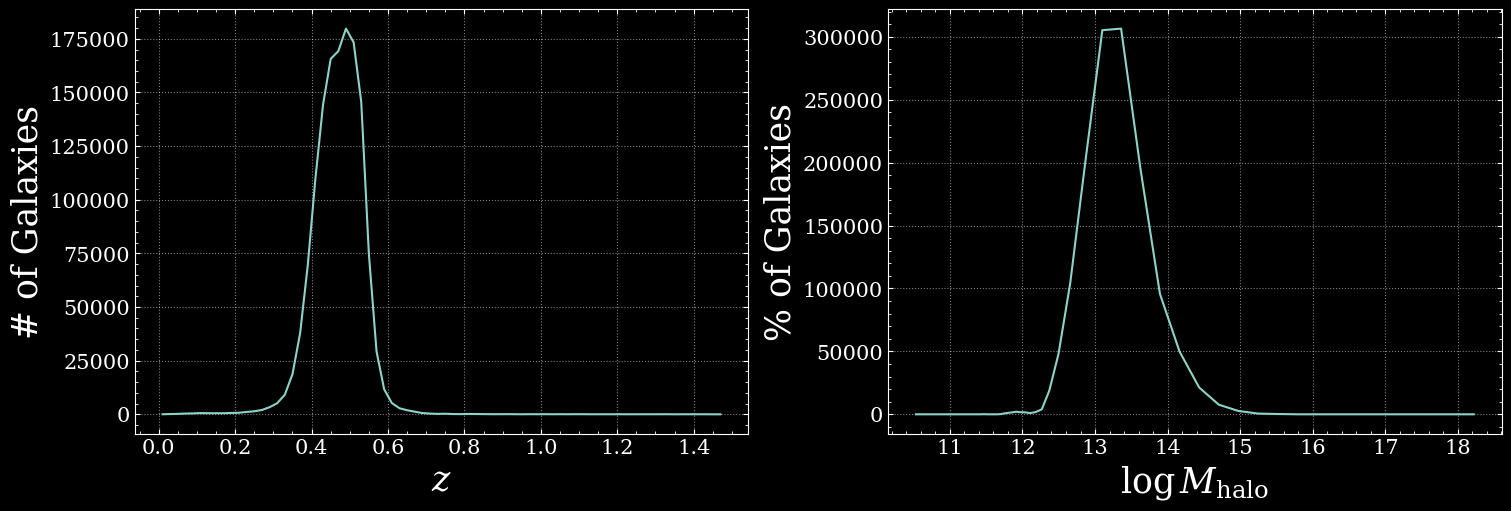

In [297]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

axs[0].plot(smf.z, smf.N_z(**cpars))
axs[1].plot(shmr.SHMR(smf.logmstar)(), smf.N_m(**cpars))

axs[0].set(xlabel=r'$z$', ylabel=r'# of Galaxies')
axs[1].set(xlabel=r'$\log M_\text{halo}$', ylabel=r'% of Galaxies')

plt.show()

In [ ]:
# Radial bins are chosen somewhat arbitrarily here
rs = np.logspace(-1.5, 1.5, 100)

# Define z and m points
zbins = np.linspace(0.3, 0.6, 11)
logmhalobins = np.linspace(11, 14, 51)

# Get the HMF from the SMF using a SHMR
hmf_smf = smf.dndlogmhalo(lambda mstar: shmr.SHMR(mstar)(), **cpars)

# Interpolate to desired points
logmhalos = (logmhalobins[1:]+logmhalobins[:-1])/2
zs = (zbins[1:]+zbins[:-1])/2
intp_points = np.stack(np.meshgrid(zs, logmhalos, indexing='ij'), axis=-1)
dndlogmhalo_smf = RegularGridInterpolator((smf.z, smf.logmhalo), hmf_smf*[logmhalos[1]-logmhalos[0]], bounds_error=False, fill_value=np.nan)(intp_points)
dNdz = np.interp(zs, smf.z, smf.dNdz_z(**cpars)*(smf.z[1]-smf.z[0]))/(zs[1]-zs[0])

We define our profiles, both the one-halo and two-halo component, and then sum to get the total. These can also be replaced with any input array of profile, so long as it matches the formatting and mass/redshift dimensionalities.

In [ ]:
from Models import FFTs
fft = FFTs.mcfit_package(rs)
ks = fft.ks

Hs, rhocs, r200cs = H(zs), rhoc(zs), r200c(zs, logmhalos)
Plins, bhs = Plin(ks, zs), bh(zs, logmhalos)

Pth1h = Pth1hmodel.Pth1h(rs, zs, logmhalos, rhocs, r200cs, **cpars)
Pth2h = lambda p={}: Pth2hmodel.Pth2h(rs, zs, logmhalos, rhocs, r200cs, Plins, bhs, dndlogmhalo_smf,fft.FFT3D, fft.IFFT3D, ks, **cpars)(p)[..., None]
Pth = lambda params={}: Pth1h(params)+Pth2h(params)

rho1h = rho1hmodel.rho1h(rs, zs, logmhalos, rhocs, r200cs, **cpars)
rho2h = lambda p={}: rho2hmodel.rho2h(rs, zs, logmhalos, rhocs, r200cs, Plins, bhs, dndlogmhalo_smf, fft.FFT3D, fft.IFFT3D, ks, **cpars)(p)[..., None]
rho = lambda params={}: rho1h(params)+rho2h(params)

Average profiles can be calculated simply with just a weighted average using the SMF and a redshift distribution, or we can use the HOD method to obtain an average profile

In [ ]:
from Models import Spectra
importlib.reload(Spectra)

hmf_hmod = hmf_hmod_func(zs, logmhalos)
Nc, Ns = hod.Nc(logmhalos), hod.Ns(logmhalos)
uck, usk = hod.uck(), hod.usk(rs, r200cs, fft.FFT3D)

aveprof_hod = Spectra.HODweighting(Nc, Ns, uck, usk, logmhalos, zs, hmf_hmod, fft.FFT3D, fft.IFFT1D, dNdz, **cpars)


dndzdlogmhalo = dndlogmhalo_smf/(zs[1]-zs[0])
dndzdlogmhalo_norm = dndzdlogmhalo/np.trapz(np.trapz(dndzdlogmhalo, logmhalos), zs)
aveprof_dist = lambda prof: np.trapz(np.trapz(prof*dndzdlogmhalo_norm, logmhalos), zs)

Using this functions we can also get average values for mass and redshift, and we can find pressure profile at specific points

In [413]:
# Calculate mave and zave using the averaging function
logmave, zave = aveprof_dist(logmhalos[None, None, :]), aveprof_dist(zs[None, :, None])
# We'll also need average angular diameter distance for the projection later so c
dA_ave = cosmology.angular_diameter_distance(zave).value

# Technically can do this with HOD too but get different values
aveval_hod = Spectra.HODweighting(Nc, Ns, uck, usk, logmhalos, zs, hmf_hmod, lambda val: val, lambda val: val, dNdz, **cpars)
logmave_hod, zave_hod = aveval_hod(logmhalos[None, None, :]), aveval_hod(zs[None, :, None])


Pth1h_avemz = lambda p={}: Pth1hmodel.Pth1h(rs, zave, logmave, rhoc(zave), r200c(zave, logmave), **cpars)(p)[:, 0, 0]
# Only use logmave for the bias in 2h calculation because the other parts need it for the integral
Pth2h_avemz = lambda p={}: Pth2hmodel.Pth2h(rs, zave, logmhalos, rhoc(zave), r200c(zave, logmhalos), Plin(ks, zave), bh(zave, logmave), dndlogmhalo_smf,fft.FFT3D, fft.IFFT3D, ks, **cpars)(p)[..., None][:, 0, 0]
Pth_avemz = lambda params={}: Pth1h_avemz(params)+Pth2h_avemz(params)

rho1h_avemz = lambda p={}: rho1hmodel.rho1h(rs, zave, logmave, rhoc(zave), r200c(zave, logmave), **cpars)(p)[:, 0, 0]
rho2h_avemz = lambda p={}: rho2hmodel.rho2h(rs, zave, logmhalos, rhoc(zave), r200c(zave, logmhalos), Plin(ks, zave), bh(zave, logmave), dndlogmhalo_smf, fft.FFT3D, fft.IFFT3D, ks, **cpars)(p)[..., None][:, 0, 0]
rho_avemz = lambda params={}: rho1h_avemz(params)+rho2h_avemz(params)

Let's take a look

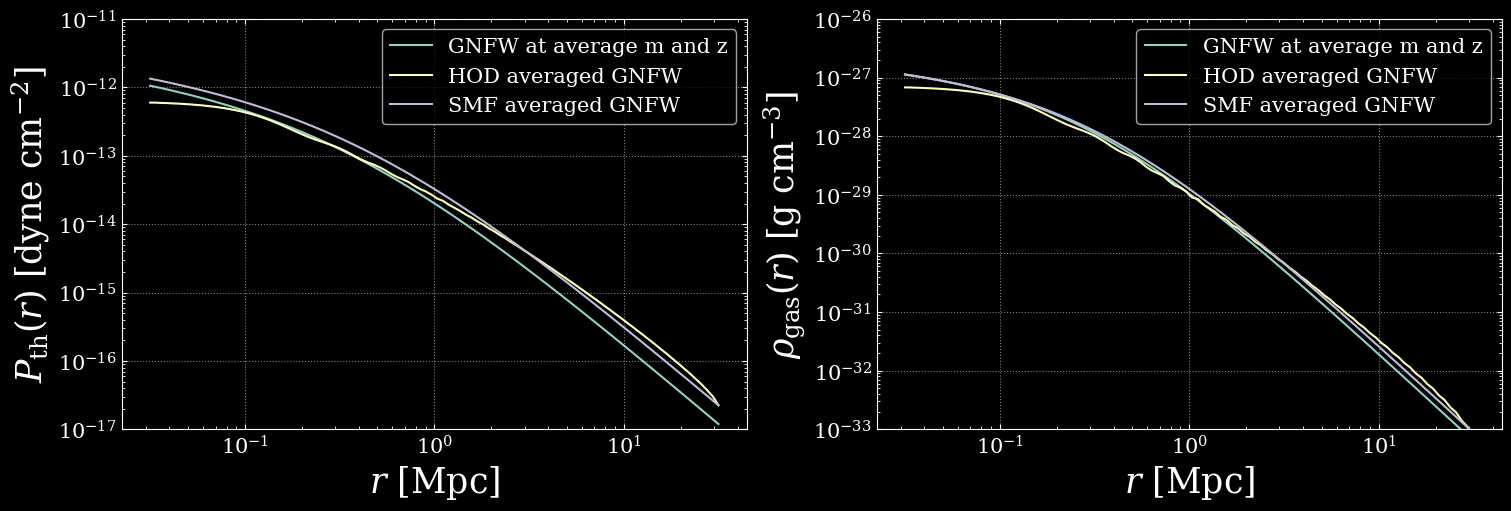

In [406]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

axs[0].loglog(rs, Pth_avemz(), label='GNFW at average m and z')
axs[0].loglog(rs, aveprof_hod(Pth()), label='HOD averaged GNFW')
axs[0].loglog(rs, aveprof_dist(Pth()), label='SMF averaged GNFW')

axs[1].loglog(rs, rho_avemz(), label='GNFW at average m and z')
axs[1].loglog(rs, aveprof_hod(rho()), label='HOD averaged GNFW')
axs[1].loglog(rs, aveprof_dist(rho()), label='SMF averaged GNFW')

axs[0].set(ylabel=r'$P_\text{th}(r)$ [dyne cm$^{-2}$]', xlabel=r'$r$ [Mpc]', ylim=(1e-17, 1e-11)); axs[0].legend(title=f'')
axs[1].set(ylabel=r'$\rho_\text{gas}(r)$ [g cm$^{-3}]$', xlabel=r'$r$ [Mpc]', ylim=(1e-33, 1e-26)); axs[1].legend(title=f'')

plt.show()

With an average profile, we can project and convolve it with a beam to get a final predicted signal

In [407]:
from Models import Projections
importlib.reload(Projections)

dust_uK = tSZdust.dust_uKarcmin(tSZmeas.thetas, 150)()/(cpars['T_CMB']*1e6*Projections.fnu(150, **cpars))
# tSZ_uK = Projections.Pth_to_uK(rs, tSZmeas.thetas, dA_ave, tSZmeas.beam_data, tSZmeas.beam_ells, tSZmeas.resp_data, tSZmeas.resp_ells, **cpars)
tSZ_y = Projections.Pth_to_y(rs, tSZmeas.thetas, dA_ave, tSZmeas.beam_data, tSZmeas.beam_ells, **cpars)

kSZ_uK = Projections.rho_to_uK(rs, kSZmeas.thetas, dA_ave, kSZmeas.beam_data, kSZmeas.beam_ells, **cpars)

Now with all of our forward model functions defined, the process of going from any input profile is simple and easy, and only dependent on some input profile (and HOD parameters if using that method). The profile can be from some model dependant on some parameters, or could be just some array from a simulation or such

In [389]:
rhos_sim = np.array([
  0.00e+00, 0.00e+00, 3.24e-27, 1.56e-27, 4.91e-27, 5.22e-27, 6.38e-27, 5.70e-27,4.12e-27, 2.34e-27, 1.27e-27, 8.04e-28, 3.44e-28, 2.89e-28, 1.87e-28, 2.24e-28,
  2.29e-28, 2.29e-28, 2.43e-28, 1.86e-28, 2.86e-28, 1.82e-28, 2.17e-28, 2.20e-28,2.36e-28, 2.44e-28, 1.41e-28, 1.41e-28, 1.22e-28, 1.06e-28, 7.01e-29, 4.04e-29,
  3.16e-29, 2.18e-29, 1.69e-29, 1.13e-29, 7.89e-30, 4.39e-30, 3.12e-30, 2.38e-30,1.98e-30, 2.15e-30, 3.32e-30, 1.93e-30, 2.53e-30, 2.02e-30, 1.54e-30, 1.35e-30,
  1.34e-30, 1.20e-30
])

pths_sim = np.array([
  0.00e+00, 0.00e+00, 2.05e-12, 6.94e-13, 2.86e-12, 1.98e-12, 6.43e-12, 1.78e-12,2.20e-12, 6.60e-13, 5.43e-13, 7.55e-14, 9.40e-14, 4.08e-14, 3.33e-14, 3.19e-14,
  5.09e-14, 4.13e-14, 5.64e-14, 5.07e-14, 6.17e-14, 6.61e-14, 7.85e-14, 8.55e-14,7.64e-14, 5.41e-14, 3.72e-14, 3.23e-14, 2.77e-14, 2.18e-14, 1.32e-14, 6.97e-15,
  4.42e-15, 2.97e-15, 2.16e-15, 1.36e-15, 7.54e-16, 4.47e-16, 3.39e-16, 2.71e-16,2.06e-16, 1.70e-16, 3.96e-16, 2.00e-16, 4.36e-16, 1.95e-16, 8.98e-17, 1.35e-16,
  2.02e-16, 7.82e-17
])

rs_sim = np.array([
  4.91e-03, 5.63e-03, 6.47e-03, 7.43e-03, 8.53e-03, 9.79e-03, 1.12e-02, 1.29e-02,1.48e-02, 1.70e-02, 1.95e-02, 2.24e-02, 2.58e-02, 2.96e-02, 3.40e-02, 3.90e-02,
  4.48e-02, 5.14e-02, 5.90e-02, 6.77e-02, 7.78e-02, 8.93e-02, 1.03e-01, 1.18e-01,1.35e-01, 1.55e-01, 1.78e-01, 2.05e-01, 2.35e-01, 2.70e-01, 3.10e-01, 3.56e-01,
  4.08e-01, 4.69e-01, 5.38e-01, 6.18e-01, 7.09e-01, 8.14e-01, 9.35e-01, 1.07e+00,1.23e+00, 1.42e+00, 1.63e+00, 1.87e+00, 2.14e+00, 2.46e+00, 2.82e+00, 3.24e+00,
  3.72e+00, 4.27e+00
])

pths_rs_tng = np.array([0.09735424212979801, 0.11446896147997443, 0.13287623169809712, 0.15362113758871032, 0.17221606221203137, 0.19826337974629682, 0.2277724256872763, 0.2679874304309756, 0.31234767720329204, 0.31234767720329204, 0.3608436815547468, 0.42170607640997093, 0.5150571395458128, 0.5150571395458128, 0.6240433245901091, 0.7321245813568327, 0.7321245813568327, 0.8661377059588243, 0.8661377059588243, 1.0422996561206148, 1.2170667986176908, 1.426952746276995, 1.426952746276995, 1.7006553614142659, 2.095639760678499, 2.095639760678499, 2.5115744416981904, 2.5115744416981904, 2.9193668567598205, 3.4524262847682565, 4.247484877569281, 4.247484877569281, 5.17723276029512, 5.17723276029512, 6.1938706804885255, 6.1938706804885255, 7.4131329211151185])

pths_tng = np.array([5.774035474115107e-13, 4.815085675792988e-13, 3.813087617341442e-13, 3.2558720116811835e-13, 2.7618808829277226e-13, 2.0340134138982603e-13, 1.6087922540021198e-13, 1.2249673051011058e-13, 8.342006148625312e-14, 8.342006148625312e-14, 5.822515917473975e-14, 3.9069655545638816e-14, 2.3691277491484658e-14, 2.3691277491484658e-14, 1.5594688994690292e-14, 1.0882084316865373e-14, 1.0882084316865373e-14, 7.432975529208199e-15, 7.432975529208199e-15, 5.208438366466413e-15, 3.840733848216323e-15, 2.826519662822993e-15, 2.826519662822993e-15, 2.374715681254344e-15, 2.0462101177032056e-15, 2.0462101177032056e-15, 1.790379800241952e-15, 1.790379800241952e-15, 1.440473163197054e-15, 1.1918595710163578e-15, 8.83184299801307e-16, 8.83184299801307e-16, 6.690758195019232e-16, 6.690758195019232e-16, 5.245550014972146e-16, 5.245550014972146e-16, 4.167742695912468e-16])


rhos_rs_tng = np.array([0.09716867643885964, 0.12693664973488744, 0.16221910134957807, 0.16221910134957807, 0.19691405397799885, 0.19691405397799885, 0.2587583482952708, 0.2587583482952708, 0.3189592466889161, 0.3189592466889161, 0.40911376299397206, 0.502892898252561, 0.502892898252561, 0.6480367277118564, 0.8539693576751319, 0.8539693576751319, 1.111761787841403, 1.484460013989758, 1.9853101729749185, 2.548184101528639, 3.3401217233829015, 3.3401217233829015, 4.392132101566211, 5.666280728768664, 5.666280728768664, 7.296947427015087, 7.296947427015087])
rhos_tng = np.array([5.78041579336038e-28, 4.525266844714718e-28, 3.6383355341625385e-28, 3.6383355341625385e-28, 2.868391578668586e-28, 2.868391578668586e-28, 1.8400088807598735e-28, 1.8400088807598735e-28, 1.319389603175651e-28, 1.319389603175651e-28, 8.406108999615177e-29, 5.636518222937302e-29, 5.636518222937302e-29, 3.483538900275164e-29, 1.8966327164232462e-29, 1.8966327164232462e-29, 1.2475744067879488e-29, 7.83891791041636e-30, 5.70629239018129e-30, 4.1774764143862544e-30, 3.166832197921344e-30, 3.166832197921344e-30, 2.404735034451457e-30, 1.9729475269561057e-30, 1.9729475269561057e-30, 1.6097377740626192e-30, 1.6097377740626192e-30])

rhos_sim = np.interp(rs, rs_sim, rhos_sim, right=0)
pths_sim = np.interp(rs, rs_sim, pths_sim, right=0)
pths_tng = np.interp(rs, pths_rs_tng, pths_tng, right=0)
rhos_tng = np.interp(rs, rhos_rs_tng, rhos_tng, right=0)

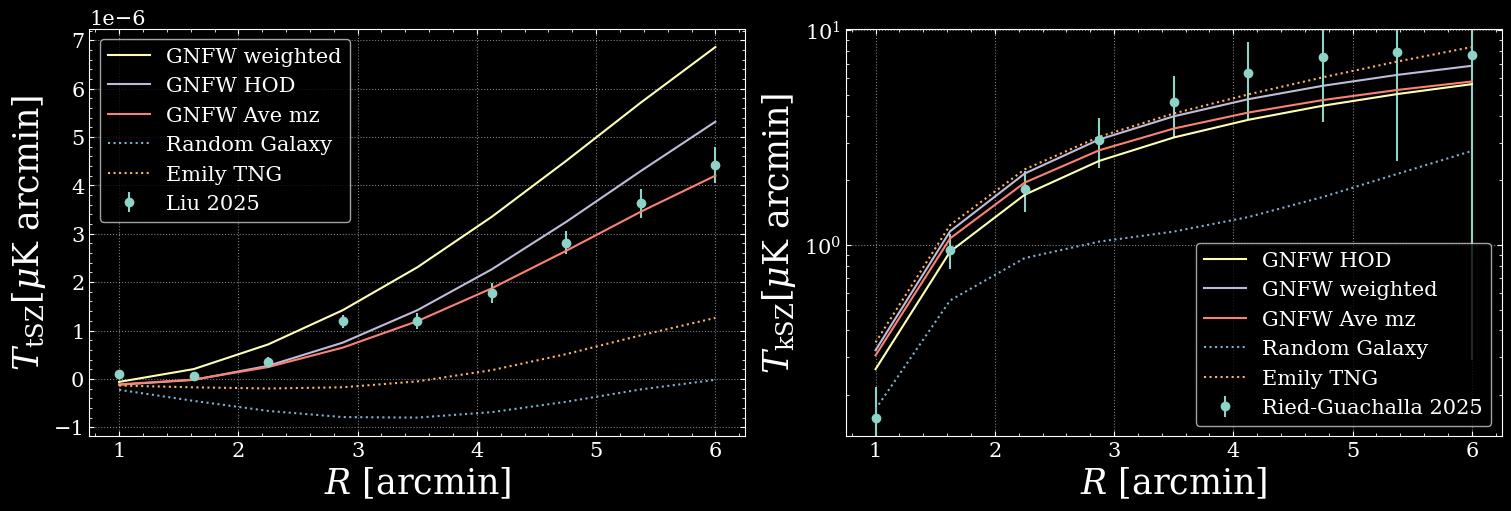

In [412]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), layout='constrained')

axs[0].set(xlabel=r'$R$ [arcmin]', ylabel=r'$T_\text{tSZ} [\mu \text{K arcmin}]$')
axs[1].set(xlabel=r'$R$ [arcmin]', ylabel=r'$T_\text{kSZ} [\mu \text{K arcmin}]$', yscale='log')

axs[0].errorbar(tSZmeas.thetas, tSZmeas.tSZdata, tSZmeas.tSZerr, marker='o', ls='', label='Liu 2025')
axs[0].plot(tSZmeas.thetas, tSZ_y(aveprof_dist(Pth()))+dust_uK, label='GNFW weighted')
axs[0].plot(tSZmeas.thetas, tSZ_y(aveprof_hod(Pth()))+dust_uK, label='GNFW HOD')
axs[0].plot(tSZmeas.thetas, tSZ_y(Pth_avemz())+dust_uK, label='GNFW Ave mz')
axs[0].plot(tSZmeas.thetas, tSZ_y(pths_sim)+dust_uK, ls=':', label='Random Galaxy')
axs[0].plot(tSZmeas.thetas, tSZ_y(pths_tng)+dust_uK, ls=':', label='Emily TNG')

axs[1].errorbar(kSZmeas.thetas, kSZmeas.kSZdata, kSZmeas.kSZerr, marker='o', ls='', label='Ried-Guachalla 2025')
axs[1].plot(kSZmeas.thetas, kSZ_uK(aveprof_hod(rho())), label='GNFW HOD')
axs[1].plot(kSZmeas.thetas, kSZ_uK(aveprof_dist(rho())), label='GNFW weighted')
axs[1].plot(kSZmeas.thetas, kSZ_uK(rho_avemz()), label='GNFW Ave mz')
axs[1].plot(kSZmeas.thetas, kSZ_uK(rhos_sim)+dust_uK, ls=':', label='Random Galaxy')
axs[1].plot(kSZmeas.thetas, kSZ_uK(rhos_tng)+dust_uK, ls=':', label='Emily TNG')

axs[0].legend(), axs[1].legend(); plt.show()

# C_ells testing: in progress

In [409]:
import sys
sys.path.append('/global/homes/c/cpopik/')
from Basics import *

cellspath = ("/global/homes/c/cpopik/Stacking_Correlating")
ViewDataOrganization(cellspath)

No README file
/global/homes/c/cpopik/Stacking_Correlating/                                                           (287 MB) 4 Dirs
     untitled.txt                                                                                             (1 MB)
     Stacking Target Stamps from Maps.ipynb                                                                   (1 MB)
     untitled.py                                                                                              (1 MB)
     DESI_Catalogs.ipynb                                                                                      (2 MB)
     ACTDR6DESILRG_Spectra_NEW2.h5                                                                            (1 MB)
     dataplotting.py                                                                                          (1 MB)
     .ipynb_checkpoints/                                                                                      (2 MB) 8 Files
     images.h5                         

In [392]:
with h5py.File("/global/homes/c/cpopik/Stacking_Correlating/ACTDR6DESILRG_Spectra_NEW.h5", "r") as f:
    print("Keys:", list(f['TxI'].keys()))
    print("Keys:", list(f['TxI/cib_cibdBeta_cibdT/1'].keys()))

Keys: ['cib', 'cib_cibdBeta', 'cib_cibdBeta_cibdT', 'cib_cibdT']
Keys: ['1.0_10.7', '1.2_10.7', '1.4_10.7', '1.6_10.7', '1.7_10.7', '1.8_10.7', '2.0_10.7']


In [410]:
from Models import Spectra
importlib.reload(Spectra)

ells = np.geomspace(55, 10000, 75)
chis = chi(zs)



Cgg1hk = Spectra.Kou2023().Cgg1h(ells, ks, zs, chis, Hs, dNdz, Nc, Ns, usk, logmhalos, hmf_hmod)
Cgg2hk = Spectra.Kou2023().Cgg2h(ells, ks, zs, chis, Hs, dNdz, Nc, Ns, usk, logmhalos, hmf_hmod, bhs, Plins)
SNk = Spectra.Kou2023().SN(ells, smf.info['area'], dNdz, zs)

Cgy1hk = Spectra.Kou2023().Cgy1h(ells, ks, zs, chis, Hs, dNdz, Nc, Ns, usk, logmhalos, hmf_hmod, fft.FFT3D, tSZmeas.beam_ells, tSZmeas.beam_data, **cpars)
Cgy2hk = Spectra.Kou2023().Cgy2h(ells, ks, zs, chis, Hs, dNdz, Nc, Ns, usk, logmhalos, hmf_hmod, fft.FFT3D, bhs, Plins, tSZmeas.beam_ells, tSZmeas.beam_data, **cpars)

Cgg1ho = Spectra.Kusiak2023().Cgg_1h(Nc, Ns, usk, hmf_hmod, logmhalos, Hs, chis, dNdz, zs, ells, ks)
Cgg2ho = Spectra.Kusiak2023().Cgg_2h(ells, Nc, Ns, usk, hmf_hmod, logmhalos, Hs, chis, dNdz, zs, ks, Plins, bhs)
SNo = Spectra.Kusiak2023().SN(smf.info['area'], dNdz, ells, zs)

/global/u2/c/cpopik/CAPPIBARAS/Models/HODs.py:31: RuntimeWarning: invalid value encountered in power
  nsat = ((M-M_0)/M_1)**alpha


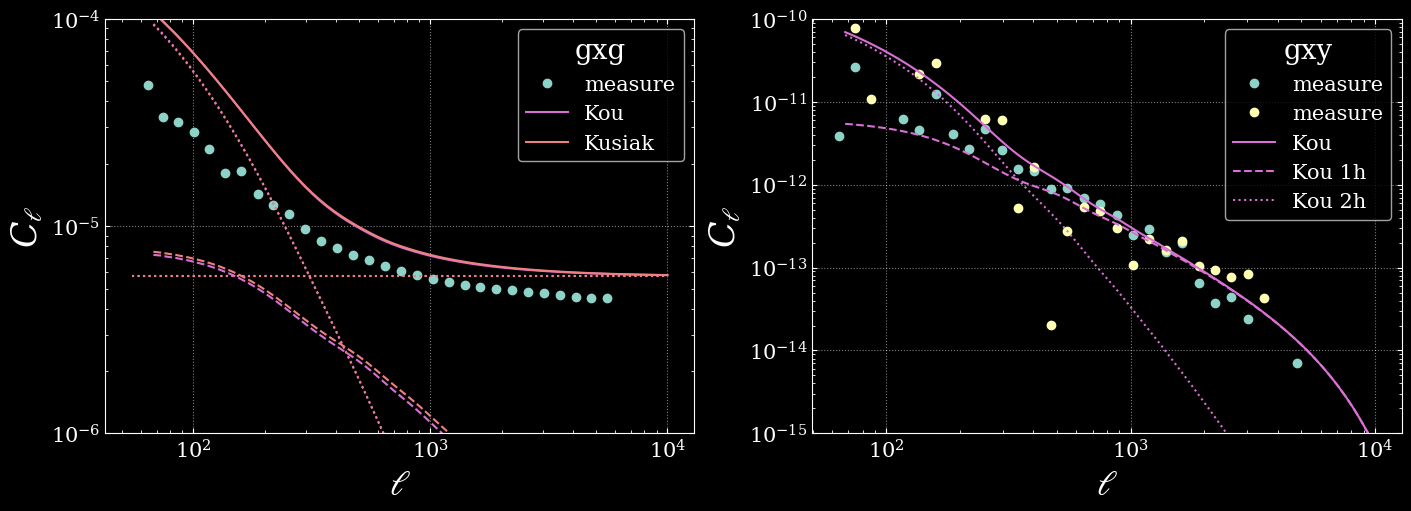

In [411]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5), layout='constrained')

with h5py.File("/global/homes/c/cpopik/Stacking_Correlating/ACTDR6DESILRG_Spectra_NEW.h5", "r") as f:
    axs[0].loglog(f['ell'][()], f['TxT/1'][()], label='measure', marker='o', ls='')

axs[0].loglog(ells, (Cgg1hk()+Cgg2hk())+SNk, label='Kou', c='orchid')
axs[0].loglog(ells, Cgg1hk(), ls='--', c='orchid')
axs[0].loglog(ells, Cgg2hk(),ls=':', c='orchid')
axs[0].loglog(ells, SNk, ls=':', c='orchid')

axs[0].loglog(ells, (Cgg1ho()+Cgg2ho())+SNo, label='Kusiak', c='lightcoral')
axs[0].loglog(ells, Cgg1ho(), ls='--', c='lightcoral')
axs[0].loglog(ells, Cgg2ho(), ls=':', c='lightcoral')
axs[0].loglog(ells, SNo, ls=':', c='lightcoral')

with h5py.File("/global/homes/c/cpopik/Stacking_Correlating/ACTDR6DESILRG_Spectra_NEW.h5", "r") as f:
    axs[1].loglog(f['ell'][()], f['TxI/cib_cibdBeta/1/1.2_10.7'][()], label='measure', marker='o', ls='')
    axs[1].loglog(f['ell'][()], f['TxI/cib_cibdBeta_cibdT/1/1.6_10.7'][()], label='measure', marker='o', ls='')

axs[1].loglog(ells, (Cgy1hk(Pth())+Cgy2hk(Pth())), label='Kou', c='orchid')
axs[1].loglog(ells, Cgy1hk(Pth()), label='Kou 1h', ls='--', c='orchid')
axs[1].loglog(ells, Cgy2hk(Pth()), label='Kou 2h', ls=':', c='orchid')

axs[0].set(ylim=(1e-6, 1e-4), ylabel=r'$C_\ell$', xlabel='$\ell$'); axs[0].legend(title='gxg')
axs[1].set(ylim=(1e-15, 1e-10), ylabel=r'$C_\ell$', xlabel='$\ell$'); axs[1].legend(title='gxy')

plt.show()